In [2]:
%matplotlib inline
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'
from modsim import *
from matplotlib.pyplot import scatter
from netCDF4 import Dataset
from datetime import date, timedelta

### Noor :)
# Final Project 

#### To Run This Notebook:
Make sure you have NetCDF4 installed! The terminal command is `pip install netCDF4`.

## Question 
The first dip into a pool is probably a very anticipatory moment for many people. I come across this a lot because I enjoy swimming and since I usually swim in unheated outdoor pools, it's often a toss-up on how warm the water is. Although I've come to expect anything, the feeling of easing into a cozy pool is hard to beat - wouldn't it be neat to know when we could expect that? 

This brings me to my driving modeling question: In the past year, what were the most comfortable days to go swimming in the average inground, unheated, outdoor pool in South Hadley?

#### Iteration Question
How does a pool's surface area affect the number of such days?

## Model

The model went through a few phases before becoming a full-cut model - chronologically, it was sketched out as a **stock-and-flow** diagram, written out **mathematically**, and tested out on **sub-models** before coming together as a Python **model** and **iterated**.

#### Note: Sources consolidated at the end

### Stock-and-Flow 
![Stock and Flow Diagram](Stock_and_Flow.jpg)

### Differential Equations
The mathematical representation is basically Newton's Law of Cooling, which we've seen in class: $\frac{dT_w}{dt} = -r(T_w - T_{air})$, where $T_w$ is the pool temperature and $T_{air}$ is the air temperature at 2m above the surface. 

#### r
We use the equation $r = \frac{hA}{M_pc_w}$ where A is the pool's surface area ($[m^2]$), $M_p$ is its mass ($[kg]$), and $c_w$ is the specific heat capacity of water ($\frac{[J]}{[kg][^\circ C]}$). r has units of $time^{-1}$, so $\frac{1}{[s]}$ in our case.

To calculate the heat transfer coefficient, I estimated equations for a horizontal plate from its [Wikipedia page](https://en.wikipedia.org/wiki/Heat_transfer_coefficient). The equation used is $h=\frac{k0.5Ra^{1/4}}{L}$, where h is the heat transfer coefficient ($\frac{[W]}{[m^2][^\circ C]}$) and k is thermal conductivity ($\frac{[W]}{[m][^\circ C]}$). L is the "characteristic length", or the ratio of surface area to perimeter ($[m]$).  

The value 0.5 is estimated from the various equations to calculate heat transfer coefficients in different types of flow - I took the estimated average to make life easier! :)

Ra is [Rayleigh's](https://en.wikipedia.org/wiki/Rayleigh_number) number (value associated with a fluid' flow), equal to $Gr*Pr$, which is [Grashof's](https://en.wikipedia.org/wiki/Grashof_number) (describes relationship between buoyancy and viscosity in a fluid) and [Prandtl's](https://en.wikipedia.org/wiki/Prandtl_number) number (describes relationship between momentum and thermal diffusivity) respectively.

### Assumptions
1. I assume the pool is more affected by the air directly above it, so I got data for air temperatures 2m above land.
<br><br>
    1. I also used data for the maximum temperature each day in the past year, rather than the average. I'm still not entirely sure if this was a good assumption, but I figured it made sense because it feels more likely that people will swim during the warmest time of the day.
<br><br>
2. I estimated equation constants for the heat transfer coefficient from Wikipedia - they went a lot into laminar and turbulent flow and had a few different equations for each kind. I assumed the difference wouldn't be too impactful, so I estimated the average of all the constants.
<br><br>
    1. It's worth noting that constant density, kinetic viscosity, coefficient of thermal expansion, and thermal conductivity were *not* assumed because those properties vary quite a bit by temperature! Since we're looking at water across a range of temperatures, it was worth the extra work to get those functions.
<br><br>

3. Although it was explored briefly, the effects of sunlight were completely ignored in the main model which I'd say is a bad assumption for the summer. 
<br><br>
4. While the pool is in-ground and we know the ground heats up when it's hot outside, I ignore the effect it (probably) has on pool water. I also don't think this is a good assumption to make! 
<br><br>
5. I also don't factor in the effect of wind (bad assumption), and I assume pressure is at sea level (solid assumption I think, since we're on the coast).

### Setting Up
I needed a swimming pool to do simulations on and also wanted it to be sized somewhat accurately to the ones around the Pioneer Valley. I used Google Earth (and regular Google) to find outdoor pools near South Hadley and measured their lengths and widths (in meters). I then took the average of these dimensions to set my pool's length and width! I also assumed a depth of **1.5m**, because that feels reasonable to swim laps in.

| Name | Location | Length (m) | Width (m)|
|:--------:|:-------:|:---------:|:----------:|
| Memorial Pool | Springfield | 22.3 | 12.4 |
| Memorial Pool | Amherst | 22.4 | 13.1 |
| Mill River Pool | Amherst | 22.9 | 13.3 |
| Sarah S. Sherman Pool | Chicopee | 23.1 | 12.5 | 

In this model, we use SI units for everything but temperature, which is in Celsius ($^\circ C$).

In [3]:
#Average pool dimensions 
avg_len = (22.3+22.4+22.9+23.1)/4  #m
avg_width = (12.4+13.1+13.3+12.5)/4  #m

#Pool depth is constant
pool_depth = 1.5  #m

c_w = 4200 #Specific heat of water, J/Kg/C

4200

### Python Model
Since temperatures in Western Massachusetts vary a lot over a year and the properties of water tend to change depending on temperature, I didn't want to assume they'd be constant because it likely does effect heat retention/loss.

The main four varying properties I needed were water's **density**, **coefficient of thermal expansion** (how much volume changes given a change in temperature), **kinetic viscosity** (resistive flow of a fluid under only the force of gravity), and **thermal conductivity** (ability to conduct heat).

It would've been  time-consuming and not human readable to calculate these values from the scientific definitions/equations itself. Thankfully, these have been measured experimentally!

I found experimental graphs and online calculators (sources below) that had equations for these properties as a function of fluid temperature (in Celsius!), which is perfect because $T_w$ is a clean piece of data to pass along.

In [4]:
'''Calculates water density as function of temperature'''
def density(T_w):
    return 999.8 + 0.075*T_w + -8.9e-3*T_w**2 + 7.4e-6*T_w**3 + 4.7e-7*T_w**4 + 1.3e-9*T_w**5

'''Calculates coefficient of therm. expansion as function of temperature'''
def therm_ex_coeff(T_w):
    return (-6e-6*T_w**4 + 1.7e-3*T_w**3 - 0.2*T_w**2 + 17*T_w + 64)

'''Calculates kinetic viscosity of water as function of temperature'''
def kin_visc(T_w):
    return (2.414e-5 * 10**(247.8/(T_w+273.15-140))/density(T_w))

'''Calculates therm. conductivity of water as function of temperature'''
def therm_cond(T_w):
    return 0.57 + 1.75e-3*T_w - 6.46e-6*(T_w**2)

Then we calculate the heat transfer coefficient from the equations above.

In [5]:
'''Calculates heat transfer coefficient'''
def h_coeff(T_w, T_air, length, width):
    #Calculate variables 
    s_a = length*width
    perimeter = 2*length + 2*width
    char_length = s_a/perimeter
    beta = therm_ex_coeff(T_w)
    k = therm_cond(T_w)
    
    #Calculates Rayleigh's numbers
    grashof = (char_length**3)*9.8*abs(T_w-T_air)*k/(kin_visc(T_w)**2)
    prandtl = kin_visc(T_w)*c_w*density(T_w)/k
    raleigh = grashof*prandtl
    
    #Calculates h
    return k*0.5*(raleigh**0.25)/char_length

Now we can calculate the actual r value we need, using the equation from above. We get mass from the equation: $density = \frac{mass}{volume}$

r takes in parameters for length and width to give us flexibility in pool size, which will come in handy later ;)

In [6]:
'''Calculates r for Newtons Law of Cooling'''
def r(T_w, T_air, length, width):
    s_a = length*width
    h = h_coeff(T_w, T_air, length, width)
    pool_mass = density(T_w) * s_a * pool_depth #m = density*volume
    
    return (h*s_a)/(pool_mass*c_w) 

Now we have all the pieces to calculate r, so we can start building the model's foundation - our **update_func**, **run_simulation**, and **make_system** functions!

None of these functions are particularly different from what we've seen in our textbook except that **update_func** assumes our System's time is in terms of hours, which it then converts to seconds. 

This conversion happens because we're using (mostly) SI units and r has units of inverse seconds, so dt must be in seconds to get a temperature back! Our System has it in hours in the first place because it gives the water an appropriate amount of time to make a noticeable change, compared to the hyperfocus of seconds

In [7]:
def update_func(state, t, system):
    #Gets variables we'll need
    T, T_air = state.T_water, system.T_air
    length, width = system.pool_len, system.pool_wid
    dt = system.dt*60*60 #conversion: hours to seconds
    
    #Calculates new temperature & returns new pool state
    T += -r(T, T_air, length, width) * (T - T_air) * dt
    return State(T_water=T)

def run_simulation(system, update_func):
    init = system.init
    t_0, t_end, dt = system.t_0, system.t_end, system.dt
    
    #TimeFrame stores pool temperature over time
    frame = TimeFrame(columns=init.index)
    frame.row[t_0] = init
    
    ts = linrange(t_0, t_end, dt)
    for t in ts:
        frame.row[t+dt] = update_func(frame.row[t], t, system)
        
    return frame

Pool dimensions aren't passed into **make_system** because it's something largely left unbothered, so it didn't seem worthwhile to clutter up the code.

The functions to calculate r above do have them as parameters because it makes them useful for purposes outside of our particular ones.

In [8]:
def make_system(T_w_init, T_air_init, t_end):
    init = State(T_water = T_w_init)
    #Makes a system using init and given variables
    return System(init=init,
               T_air=T_air_init,
               pool_len = avg_len,
               pool_wid = avg_width,
               dt = 1, #hours!
               t_0 = 1,
               t_end = t_end)

### Warming Up
To get a sense of what to expect when we run the model on yearly data, I decided (definitely not influenced by anyone) to make some sub-models! 

**Note**: I assume a period of day/night is approximately 9 hours.

#### Warmer Air Temperature (Day)
The first sub-model assumes a constant air temperature higher than the pool's initial temperature and then seeing how the water's temperature changes.

,T_water
1,15
2,17.1924
3,18.2796
4,18.8747
5,19.2266
6,19.4475
7,19.5929
8,19.6922
9,19.7623


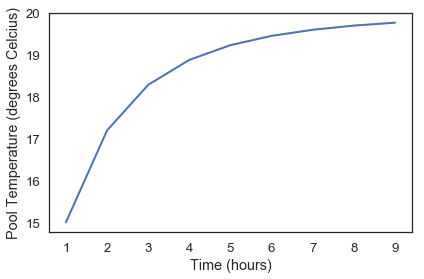

In [9]:
water = make_system(15, 20, 9) #Water: 15C, Air: 20C, Total daytime: 9hrs
results = run_simulation(water, update_func)

plot(results.T_water)
decorate(xlabel='Time (hours)',
         ylabel='Pool Temperature (degrees Celcius)')
results

Unsurprisingly, water in the pool increases over the day to level out at air temperatures - just in time for the sun to figuratively set!

#### Warmer Air Temperature + Sunlight (Day)
Sunlight doesn't factor into my main model but it would be interesting to see how it affects the pool, coupled with warm air. 

I use the [solar constant](https://en.wikipedia.org/wiki/Solar_constant) to do this, which is the average power we get on Earth from the Sun per unit area! It has units of $\frac{[W]}{[m^2]}$ - it's worth noting that $[W]=\frac{[J]}{[s]}$.

Before plotting graphs, I first created a new update function called **sun_update_func**. It calculates temperature change from Newton's Law as well as the effect of sunlight, which it then adds together to get total change. 

Energy from sunlight is calculated with the equation $Energy=Power*Time$, where $Power=G_{sc}*A$. The specific heat formula then lets us calculate the change in pool temperature as $\Delta T=\frac{Energy}{c_wM_p}$

In [10]:
#Solar constant - mean energy from sun
g_sc = 1370 #W/m^2

'''Updated update_func that accounts for energy from sunlight'''
def sun_update_func(state, t, system):
    #Calculates dT as normal
    T, T_air = state.T_water, system.T_air
    length, width = system.pool_len, system.pool_wid
    dt = system.dt*60*60
    dT = -r(T, T_air, length, width) * (T - T_air) * dt

    #Calculates additional temperature change from sun
    s_a = length*width
    pool_mass = density(T) * s_a * pool_depth
    
    sun_energy = g_sc * s_a * dt #E = P*T, P = gsc*SA
    dT_from_sun = sun_energy/(c_w*pool_mass) #from Q=mc*deltaT
    #Calculates new temperature as usual
    T += dT + dT_from_sun
    return State(T_water=T)

We run our simulation with the new update function...

,T_water
1,15
2,17.9761
3,19.4874
4,20.4042
5,21.0897
6,21.5298
7,21.786
8,21.928
9,22.0046


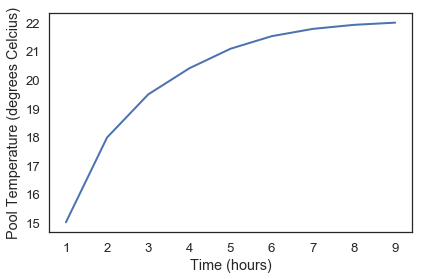

In [11]:
water = make_system(15, 20, 9) #Water: 15C, Air: 20C, Total daytime: 9hrs
results = run_simulation(water, sun_update_func)

plot(results.T_water)
decorate(xlabel='Time (hours)',
         ylabel='Pool Temperature (degrees Celcius)')
results

The quicker temperature increase is again no surprise - we'd expect sunlight to speed things up! Note that the pool temperature increases past the surrounding air's, which is likely because the sunlight is additive to Newton's Law. 

It does look like the curve levels off at a point though! I think it's because once the pool's temperature overtakes the air's, it starts losing heat to the air while still gaining heat from the sun. Eventually, this reaches equilibrium! (This only really makes sense because we assume the air isn't effected by sunlight, which probably isn't true)

#### Colder Air Temperatures (Night)
Here, we see how pool temperature's behave when the surrounding air is colder, since the water has gained all this heat during the day.

,T_water
1,20
2,17.7073
3,16.6637
4,16.1012
5,15.767
6,15.5551
7,15.4139
8,15.3162
9,15.2464


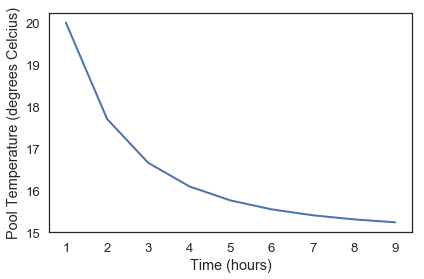

In [12]:
water = make_system(20, 15, 9) #Water: 20C, Air: 15C, Nighttime: 9hrs

results = run_simulation(water, update_func)
plot(results.T_water)
decorate(xlabel='Time (hours)',
         ylabel='Pool Temperature (degrees Celcius)')
results

We see that the pool starts losing heat, rapidly at first and then more slowly until it reaches equilibirum with the air. This assumes the air directly above it doesn't change temperature at all, which is likely not true but even then, the two would still reach equilibrium at some temperature.

### Main Model!
Now that we have a rough idea of what behavior to expect from a pool over a day, we can try to run our model over a year.

To do so, actual data is needed. We look at each day from December 1st 2018 to December 1st 2019 and extract the maximum temperature of that day into a handy list. Since we need an actual place to look at and get these from, we consider our very own South Hadley located at 42.2592° N, 72.5748° W.

In [13]:
'''Data Collection Code!'''

year = linrange(1, 366, 1)
year_vals = []

air_18 = Dataset('2018_max.nc', mode='r')
air_19 = Dataset('2019_max.nc', mode='r')

#Time in .nc files measures from 1st Jan 1800
base_time = date(2018, 12, 1) - date(1800, 1, 1)
#To check which file to extract data from (2018 or 2019)
year_end = date(2019, 1, 1) - date(1800, 1, 1) 

#Coordinates of South Hadley, & closest ones in  file
main_lat = 42.258333 #degrees North
main_lon = 360+(-72.575) #degrees W to degrees East
file_lat = (abs(air_18.variables['lat'][:] - main_lat)).argmin()
file_lon = (abs(air_18.variables['lon'][:] - main_lon)).argmin()

153

Once we have the variables to satisfy .nc files, we run through our year and get the air temperatures.

In [14]:
for i in range (1, 366): 
    #Time in hours since 1st December 2018
    curr_time = base_time.days*24 + i*24 
    
    #Gets grid index for time, either in 2018 or 2019
    grid_time = 0
    if curr_time < year_end.days*24:
        air = air_18['tmax']
        grid_time = (abs(air_18.variables['time'][:] - curr_time)).argmin()
    else:
        air = air_19['tmax']
        grid_time = (abs(air_19.variables['time'][:] - curr_time)).argmin()
    
    #Appends temperature in Celsius
    curr_temp = air[grid_time, file_lat, file_lon].data
    year_vals.append(curr_temp.item() - 273.15)

**year_vals** now contains a list of air temperatures in South Hadley from the past year. We can plot this to get a better sense of how this varies in a year - it's like a sine curve!

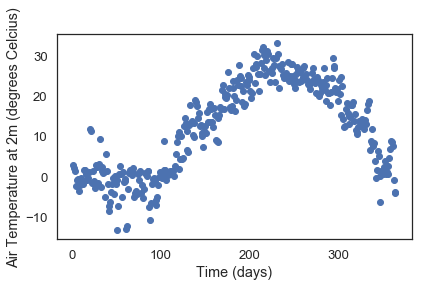

In [15]:
scatter(y=year_vals, x=year)
decorate(xlabel='Time (days)',
             ylabel='Air Temperature at 2m (degrees Celcius)')

Since we're dealing with varying air temperatures, I modify **run_simulation** to update $T_{air}$ at each timestep and to convert the timestep from days to hours. It makes more sense to pass time along in days since we're looking at it in terms of days - let functions handle the heavy lifting, not users!

In [16]:
'''Modifies run_simulation to update T_air at every point of time'''
def run_simulation(system, update_func):
    init = system.init
    t_0, t_end, dt = system.t_0, system.t_end, system.dt
    
    frame = TimeFrame(columns=init.index)
    frame.row[t_0] = init
    ts = linrange(t_0, t_end, dt)
    for t in ts:
        system.T_air = year_vals[t] #Updates air temperature
        frame.row[t+dt] = update_func(frame.row[t], t*24, system) #Conversion: Days to Hours
        
    return frame

We then run our model...

In [17]:
water = make_system(year_vals[0], year_vals[0], 365) #Time in units of days                 
results = run_simulation(water, update_func)

,T_water
1,2.749994
2,2.612866
3,2.231041
4,0.453003
5,0.100394
6,-0.075815
7,-1.313300
8,-1.454543
9,-1.640813
10,-1.333017


## Results

The fun part - plotting!

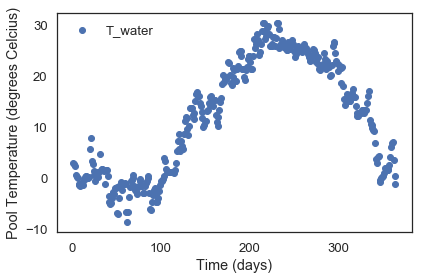

In [18]:
'''Shows us the cooling/warming of our pool over period of a year'''
scatter(y=results.T_water, x=year)
decorate(xlabel='Time (days)',
             ylabel='Pool Temperature (degrees Celcius)')

As a scatter plot, the pool's temperature change looks almost similar to the year in general so I added in a line plot to better appreciate the highs and lows.

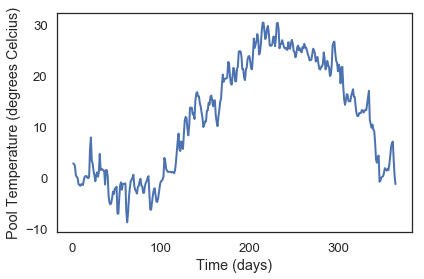

In [19]:
plot(results.T_water)
decorate(xlabel='Time (days)',
             ylabel='Pool Temperature (degrees Celcius)')

The big thing we want out of this model is to tell us what days in the past year were comfiest to swim in! To do so, we should first define what comfy is.

According to the [internet](https://www.swimuniversity.com/pool-temperature/), a pool is comfiest in the 26$^\circ$C-28$^\circ$C range. Here, we'll define it as a temperature equal to or above 26$^\circ$C since we rarely exceed 28$^\circ$C in the Pioneer Valley.

While we could use our graph to do this, it would be easier to get it written out in plain English. 

## Interpretation
To turn our plot into something useful, first we get all the rows in the resulting DataFrame that have a value for $T_{water} \geq 26^\circ C$. Then we rename the indices, because who counts things in terms of days since December 1st 2018?

In [20]:
comfy_days = results[results['T_water'] >= 26].copy()
'''Rewrites time in [day #][month name][year]'''
for i in comfy_days.itertuples():
    #Calculates date from 1st Dec 2018
    curr_date = date(2018, 12, 1) + timedelta(i.Index)
    curr_date = curr_date.strftime('%d%b%Y') #Formats to be readable
    comfy_days.rename(index={i.Index: curr_date}, inplace=True)
comfy_days

,T_water
24Jun2019,27.217520
26Jun2019,26.089140
27Jun2019,26.743746
28Jun2019,28.081624
29Jun2019,26.982517
02Jul2019,26.171160
03Jul2019,28.755124
04Jul2019,30.330413
05Jul2019,30.316121
06Jul2019,28.737911


We have the answer to our question - the days in the past year that were comfiest to swim in! Interestingly enough, it tells us late September was a good time to go swimming.

## Model Iteration
Now that we have a list of days in the past year most conducive to outdoor swimming, the next question was how the surface area of our pool could affect the number of these days.

To get started, we modify **make_system** to take in parameters for pool length and width - this makes it easier to vary dimensions for a lot of different values. 

In [21]:
'''Update make_system to take pool dimensions into account!'''
def make_system(T_w_init, T_air_init, length, width, t_end):
    init = State(T_water = T_w_init)
    return System(init=init,
               T_air=T_air_init,
               pool_len = length,
               pool_wid = width,
               dt = 1, 
               t_0 = 1,
               t_end = t_end)

Now we can sweep different surface areas using a **linrange** to cover the different sizes we want - we put the same values in for both length and width, making the pool square! (Though the shape shouldn't affect the results we get). We give users the option of choosing the maximum length/width they'd like to sweep through.

In [22]:
def sweep_surface_area(max_len):
    size_range = linrange(1, max_len, 1) 
    comfy_day_counts = SweepSeries() 
    for i in size_range:
        #Runs simulation for each ixi meter pool dimension
        water = make_system(year_vals[0], year_vals[0], i, i, 365)
        results = run_simulation(water, update_func)

        #Notes number of comfy days for swimming
        above_26 = results[results['T_water']>=26]
        comfy_day_counts[i*i] = len(above_26.index)

        if i%20==0: #Only plots certain areas for sake of time/space
            plot(results.T_water, label = str(i*i)+ r" $m^2$")
            decorate(xlabel='Time (days)',
                 ylabel='Pool Temperature (degrees Celcius)')
    return comfy_day_counts

## Results

,values
1,37
4,37
9,36
16,36
25,34
36,34
49,34
64,34
81,33
100,33


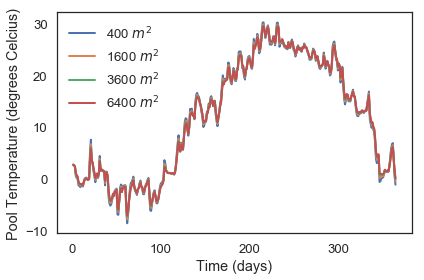

In [23]:
results = sweep_surface_area(100) #Maximum length/width = 100m

We see that the there's no drastic temperature change when we vary surface area, which I admit is doubtful. While it's hard to see, lines corresponding to larger pools/bodies of water don't increase/decrease as much compared to the smaller ones. 

## Interpretation
So we learn that smaller bodies of water lose and gain heat at a faster rate compared to bigger ones - intuitively, we know this probably means smaller pools are more likely to be at higher temperatures than larger ones when it's warm out.

The answer we can draw is that a pool with smaller surface area is comfier to swim in more days out of the past year, compared to a pool with larger surface area.

Looking at the actual data we have - of the counts of comfortable days for each surface area - will reinforce our answer.

,values
1,37
4,37
9,36
16,36
25,34
36,34
49,34
64,34
81,33
100,33


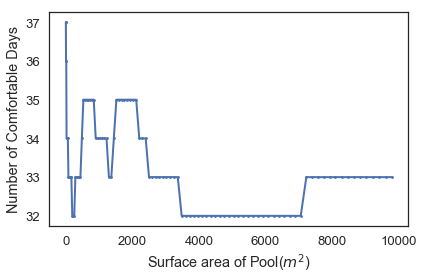

In [24]:
scatter(y=results, x=results.index, s=3)
plot(results)
decorate(xlabel= r"Surface area of Pool($m^2$)",
        ylabel="Number of Comfortable Days")
results

Weirdly enough, this graph looks a little similar to that of damped harmonic motion: 
![Damped Harmonic Motion Graph](damped_harmonic_motion.png)

The 'dampening' might imply that as the surface area of a water body increases, the temperatures don't vary as much over the year until eventually it just stays constant - this would explain why it starts leveling out at the end. I do not know what could explain the 'harmonic motion' part of it, but given more time I could figure it out!

Despite all this variation to the values, we can see from the table and the scatter plot that there's still generally an inverse relationship that answers our iterative model question - the smaller the surface area, the more pleasant days to swim!

#### Easter Egg?

With this answer in hand, it is interesting to relate it to the different pools we could come across. For example, personal pools are usually smaller than public ones so if you live in a location prone to heat waves and valued warmth when swimming, it might be worth it to install a pool on your property.

### Role of Iteration
The question and model we started with brought us a long way in this project, but they were all specific to the average dimensions we first calculated. In real life, all pools are not 22.6m by 12.8m - our iteration addresses this assumption and tells us how our answer would've changed if we had assumed different dimensions.

### Failings

A fair number of factors were ignored in this model like sunlight and wind (which I mentioned above) and our equation for h (the heat transfer coefficient) did not properly take into account laminar/turbulent flow. It's possible this might've effected the lack of temperature variance in our model iteration!

### Next Steps

I think it would be really cool to get data for solar radiance and see how our plots change taking that into account. It would also be interesting to see how the temperature of the surrounding ground effects it too because then we'd have to think about pool material and what type of land we place it in (tiled, grass, concrete etc.).

## Sources & Data

Density: https://www.omnicalculator.com/physics/water-density

Coefficient of Thermal Expansion: https://www.researchgate.net/figure/The-volumetric-coefficient-of-thermal-expansion-of-water-as-a-function-of-temperature_fig5_283292378

Kinematic Viscosity:    https://resources.saylor.org/wwwresources/archived/site/wp-content/uploads/2011/04/Viscosity.pdf

Thermal Conductivity: https://syeilendrapramuditya.wordpress.com/2011/08/20/water-thermodynamic-properties/

Heat Transfer Coefficient: 
https://www.processassociates.com/process/dimen/dn_grs.htm#
https://en.wikipedia.org/wiki/Prandtl_number
https://en.wikipedia.org/wiki/Rayleigh_number
https://en.wikipedia.org/wiki/Heat_transfer_coefficient

Sunlight: https://en.wikipedia.org/wiki/Solar_constant
http://www.softschools.com/formulas/physics/specific_heat_formula/61/

Max. Temperature @ 2m Data (scroll wayy down or Cmd+f search for tmax):
ftp://ftp.cdc.noaa.gov/Datasets/ncep.reanalysis.dailyavgs/surface_gauss/

Perfect Pool Temp:
https://www.swimuniversity.com/pool-temperature/